#P8 - GP Extra: Regresión para toda la serie histórica

Nombre:

NIP:

In [134]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from datetime import datetime, timedelta
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    ExpSineSquared,
    RationalQuadratic,
    WhiteKernel,
)

%matplotlib inline

# Funciones auxiliares de carga y visualizacion



```
def parse_multiple_files(file_list, contaminant_code)
# Read multiple files and return a data frame with the data from all available stations for the selected contaminant

def plot_station_time_series(df, station_id=None, title=None)
# plot data from the dataframe


```



In [135]:
def parse_single_file(file_path, contaminant_code):
    df = pd.read_csv(file_path, sep=';', encoding='latin1', dtype={'ESTACION': str})
    df = df[df['MAGNITUD'] == contaminant_code]

    records = []

    for _, row in df.iterrows():
        year = int(row['ANO'])
        month = int(row['MES'])
        station = row['ESTACION'].zfill(2)

        for day in range(1, 32):
            day_str = f"{day:02d}"
            value_col = f"D{day_str}"
            valid_col = f"V{day_str}"

            if valid_col in row and row[valid_col] == 'V':
                try:
                    value = float(row[value_col])
                    date = datetime(year, month, day)
                    records.append((station, date, value))
                except Exception:
                    continue

    df_time = pd.DataFrame(records, columns=["station", "date", "value"])

    # Add days-since-2000 index
    base_date = datetime(2001, 1, 1)
    df_time["INDEX"] = (df_time["date"] - base_date).dt.days

    # Pivot by station
    pivot_df = df_time.pivot_table(index="date", columns="station", values="value", aggfunc='mean')

    # Add INDEX to pivoted data
    pivot_df = pivot_df.merge(df_time[["date", "INDEX"]].drop_duplicates(), on="date", how="left")
    pivot_df.set_index("INDEX", inplace=True)
    pivot_df.sort_index(inplace=True)

    return pivot_df

def parse_multiple_files(file_list, contaminant_code):
    combined = []

    for file in file_list:
        #print(f"Processing: {file}")
        df = parse_single_file(file, contaminant_code)
        combined.append(df)

    # Combine all years
    final_df = pd.concat(combined)
    final_df = final_df[~final_df.index.duplicated(keep='first')]  # Remove duplicate INDEX values if any
    final_df.sort_index(inplace=True)

    return final_df

def plot_station_time_series(df, station_id, title=None):
    if station_id not in df.columns:
        print(f"Station {station_id} not found in the data.")
        return

    series = df[station_id].dropna()

    plt.figure(figsize=(14, 5))
    plt.plot(series.index, series.values, label=f"Station {station_id}", color='teal')
    plt.title(title or f"Air Quality Time Series – Station {station_id}")
    plt.xlabel("Days since 01-01-2000 (INDEX)")
    plt.ylabel("Pollutant Level")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_station_time_series(df, station_id=None, title=None):
    plt.figure(figsize=(14, 6))

    # Exclude non-station columns if they exist (like 'date')
    station_columns = [col for col in df.columns if col != 'date']

    if station_id:
        if station_id not in station_columns:
            print(f"Station {station_id} not found in the data.")
            return
        series = df[station_id].dropna()
        plt.plot(series.index, series.values, label=f"Station {station_id}")
    else:
        for col in station_columns:
            series = df[col].dropna()
            plt.plot(series.index, series.values, label=f"Station {col}", alpha=0.7)

    plt.title(title or (
        f"Air Quality Time Series – Station {station_id}" if station_id else "Air Quality – All Stations"
    ))
    plt.xlabel("Days since 01-01-2000 (INDEX)")
    plt.ylabel("Pollutant Level")
    plt.grid(True)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.02))
    plt.tight_layout()
    plt.show()

def get_station_series(final_data, station_id):
    """
    Returns two 1D numpy arrays: X (INDEX) and y (measurements)
    for a given station from the final_data DataFrame.

    Parameters:
    - final_data: pd.DataFrame with INDEX as index and station columns
    - station_id: str, the station code to retrieve

    Returns:
    - X: numpy array of INDEX values
    - y: numpy array of measurement values
    """
    if station_id not in final_data.columns:
        raise ValueError(f"Station '{station_id}' not found in data.")

    series = final_data[station_id].dropna()

    X = series.index.to_numpy()
    y = series.values

    return X, y

## a) Leer los ficheros y cargar el dataframe para un contaminante.

Hay disponibles 18 contaminantes (ver contaminant_name_to_code para la lista completa):

Os recomendamos trabajar con estos cuatro:_ `O3`, `N2`, `CO` y `NOx`. Algunas observaciones:


1. Cada indicador tiene medidas solo en algunos días. Esto significa que tendréis que <br>
ajustar el rango de predicción en función del indicador que elijais.

2. Algunos indicadores tienen huecos en la serie temporal, por lo que se puede predecir <br>
en los huecos. También podéis crear los huecos vosotros eliminando datos.

3. Observar los datos y proponer kernels para ajustar la serie temporal.
<!-- <br> Recordad que una suma se puede interpretar como un OR y una multiplicación como un AND. Podéis ver un ejemplo para CO2 [aqui](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html). -->

4. Podéis subsamplear los datos. Revisar la complejidad que tiene el GP a nivel computacional.

In [142]:
# List of files containing the data
file_list = {
    "datos01.csv", "datos02.csv", "datos03.csv", "datos04.csv",
    "datos05.csv", "datos06.csv", "datos07.csv", "datos08.csv",
    "datos09.csv", "datos10.csv", "datos11.csv", "datos12.csv",
    "datos13.csv", "datos14.csv", "datos15.csv",
    "datos201612.csv", "datos17.csv",
    "datos201812.CSV", "datos201912.csv", "datos202012.csv",
    "datos202112.csv", "datos202212.csv",
    "datos202312.csv", "datos202412.csv", "datos202503.csv",
}

# Code for each possible contaminant
contaminant_name_to_code = {
    "SO2": 1,
    "CO": 6,
    "NO": 7,
    "NO2": 8,
    "PM10": 10,
    "NOx": 12,
    "O3": 14,
    "TOL": 20,
    "BEN": 30,
    "EBE": 35
}


contaminant="NOx"
final_data = parse_multiple_files(file_list, contaminant_name_to_code[contaminant])

final_data.to_csv('dataframe'+contaminant+'.csv', index=False)


   Station  Start Date    End Date  Total Points  Missing Points
0       04  2000-01-01  2024-03-30          8824             315
1       08  2000-01-01  2024-03-30          8824             605
2       11  2000-01-01  2024-03-30          8824              91
3       16  2000-01-01  2024-03-30          8824             132
4       17  2000-01-01  2024-03-30          8824            1597
5       18  2000-01-01  2024-03-30          8824             148
6       24  2000-01-01  2024-03-30          8824             158
7       27  2001-12-31  2024-03-30          8824             763
8       35  2000-01-01  2024-03-30          8824             213
9       36  2000-01-01  2024-03-30          8824              73
10      38  2000-01-01  2024-03-30          8824              63
11      39  2000-01-01  2024-03-30          8824             186
12      40  2000-01-01  2024-03-30          8824              59
13      47  2008-12-20  2024-03-30          8824            3305
14      48  2009-05-31  2

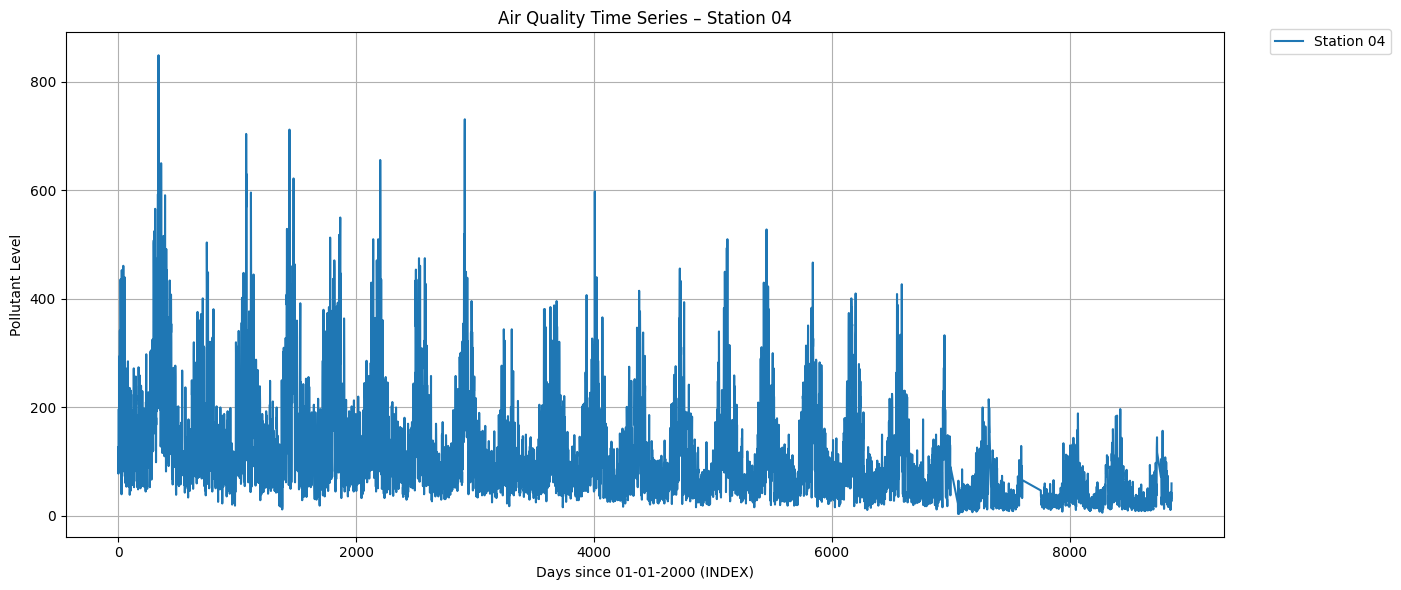

In [143]:
# Check the data statistics  and plot the time series
summary_table = summarize_station_data(final_data)
print(summary_table)

# Pick a station with data
station_id = "04"
plot_station_time_series(final_data, station_id)


# dataset a ajustar por Gaussian Process:
X, y = get_station_series(final_data, station_id)

# b) Diseño del kernel y proceso Gaussiano

Observa los datos, propón un kernel y ajusta los parámetros a mano.

# c) Optimiza el Kernel (sus hipérparámetros)

Puedes repetir esto con diferentes contaminantes. Recuerda justificar el diseño del Kernel así como discutir los resultados obtenidos en cada una de las pruebas que realices.
